In [1]:
import json
import pickle
import pathlib
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
LINE_JSON = "/kaggle/input/vn-hands/labels.json"
LINE_DATA = "/kaggle/input/vn-hands/data"

In [3]:
with open(LINE_JSON, 'r', encoding='utf8') as f:
    train_labels = json.load(f)

char_list= set()
for label in train_labels.values():
    char_list.update(set(label))
char_list=sorted(char_list)

print(len(char_list))
print("".join(char_list))

174
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXY[\]^_`abcdefghijklmnopqrstuvwxyz|}~ÀÁÂÊÔàáâãèéêìíòóôõùúýĂăĐđĩũƠơưạẢảẤấầẩẫậắằẳẵặẹẻẽẾếềểễệỉịọỏốồỔổỗộớờỞởỡợụủỨứừửữựỳỵỷỹ


In [4]:
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [5]:
encode_to_labels('Chữ viết tay')

[35, 71, 168, 0, 85, 72, 141, 83, 0, 83, 64, 88]

In [6]:
train_image_path = []
for item in pathlib.Path(LINE_DATA).glob('**/*'):
    if item.is_file() and item.suffix not in [".json"]:
        train_image_path.append(str(item))
print(train_image_path[:5])

dict_filepath_label={}
line_data_path = pathlib.Path(os.path.join(LINE_DATA))
for item in line_data_path.glob('**/*.*'):
    file_name=str(os.path.basename(item))
    if file_name != "line.json":
      label = train_labels[file_name]
      dict_filepath_label[str(item)]=label

label_lens= []
for label in dict_filepath_label.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)

print(max_label_len)

all_image_paths = list(dict_filepath_label.keys())
all_image_paths[:5]

['/kaggle/input/vn-hands/data/1122_samples.png', '/kaggle/input/vn-hands/data/4364_samples.png', '/kaggle/input/vn-hands/data/2851_samples.png', '/kaggle/input/vn-hands/data/0667_samples.png', '/kaggle/input/vn-hands/data/3620_samples.png']
89


['/kaggle/input/vn-hands/data/1122_samples.png',
 '/kaggle/input/vn-hands/data/4364_samples.png',
 '/kaggle/input/vn-hands/data/2851_samples.png',
 '/kaggle/input/vn-hands/data/0667_samples.png',
 '/kaggle/input/vn-hands/data/3620_samples.png']

In [7]:
test_size = 0.2
train_image_paths, val_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

In [8]:
TIME_STEPS = 240

training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
resize_max_width=0
i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)
    
    height, width = img.shape

    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    
    height, width = img.shape
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]

    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    
    # YOUR PART: Blur it
    img = cv2.GaussianBlur(img, (5,5), 0)

    # YOUR PART: Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_filepath_label[train_img_path]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))
print(resize_max_width)

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
2167


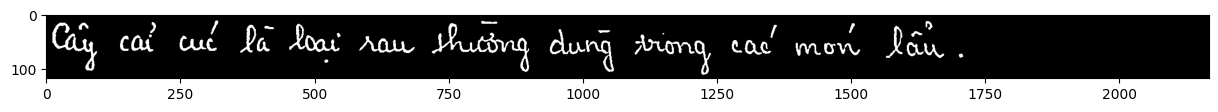

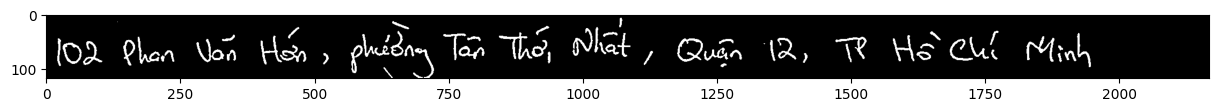

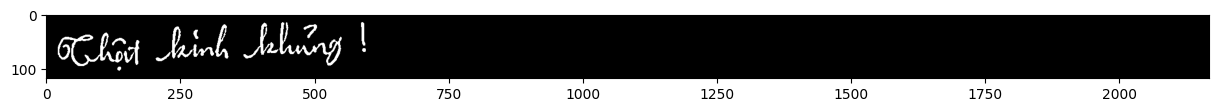

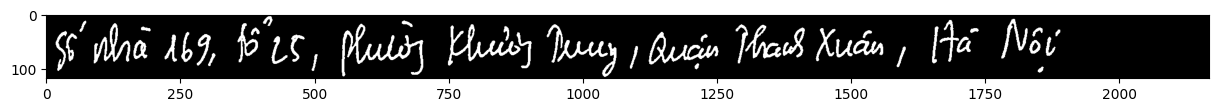

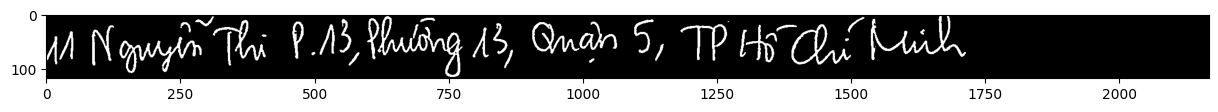

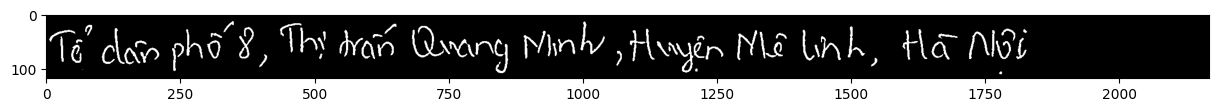

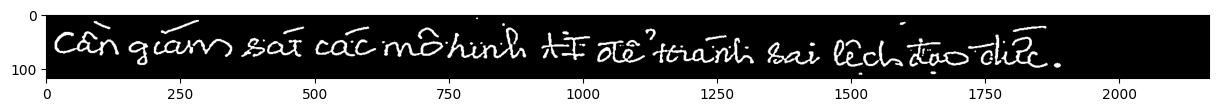

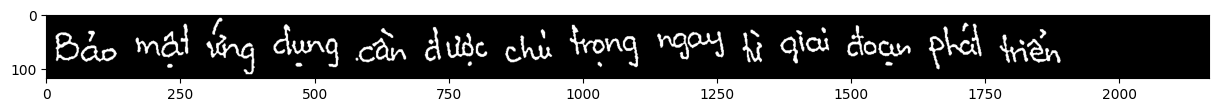

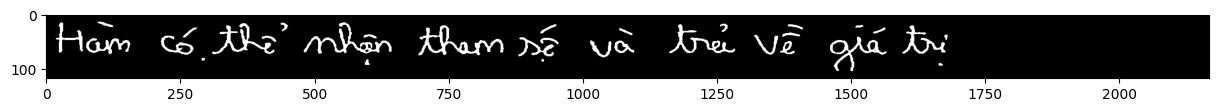

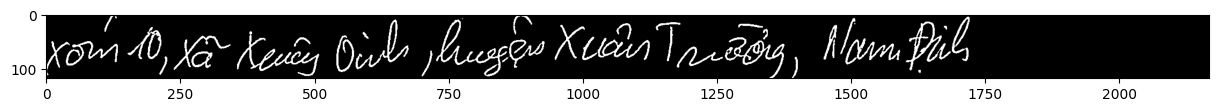

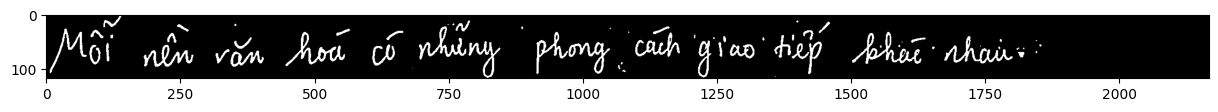

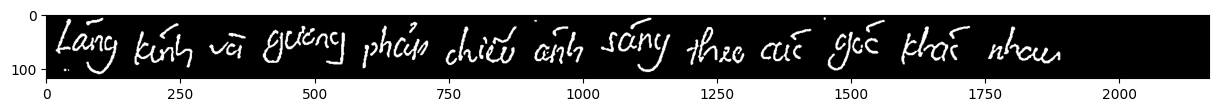

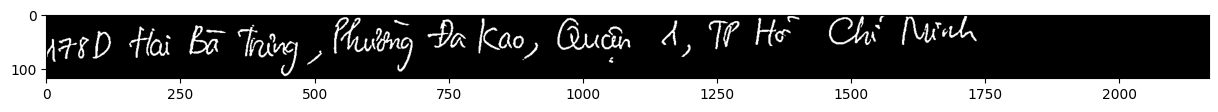

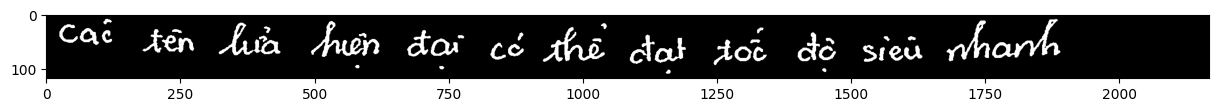

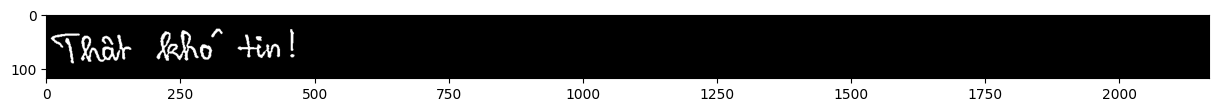

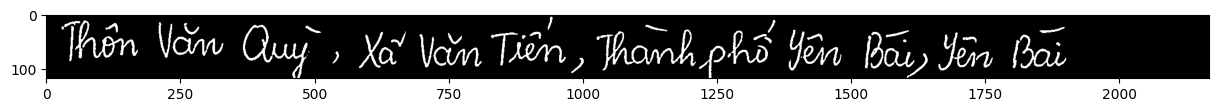

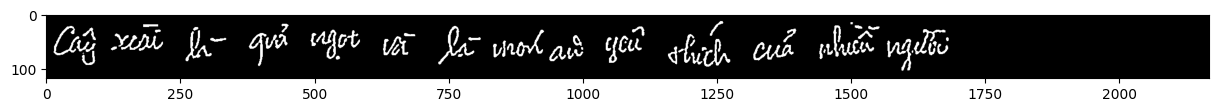

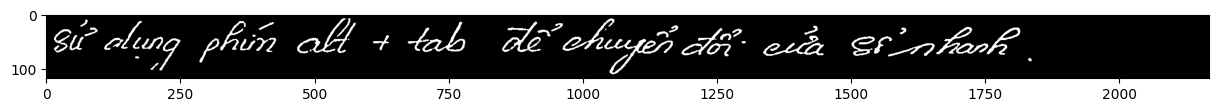

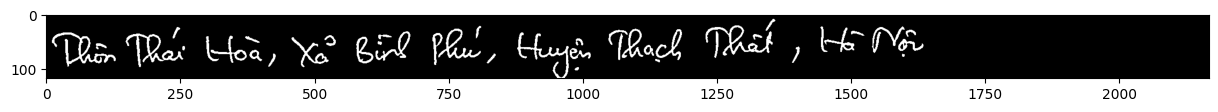

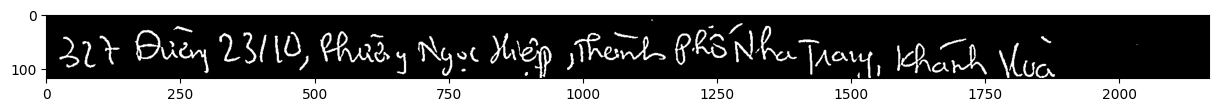

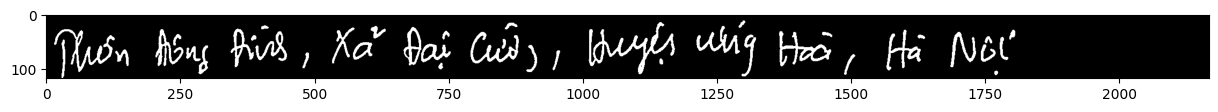

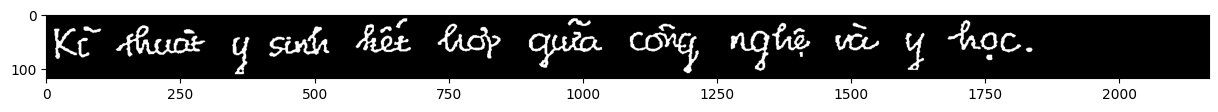

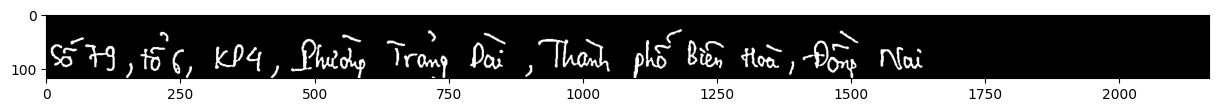

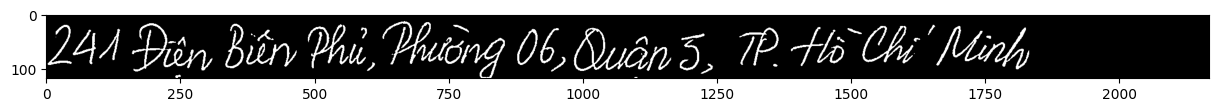

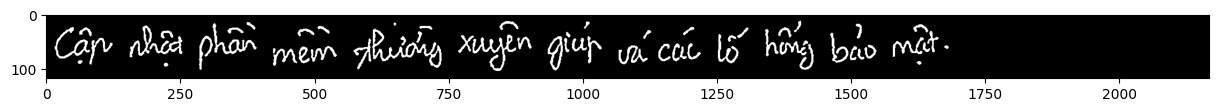

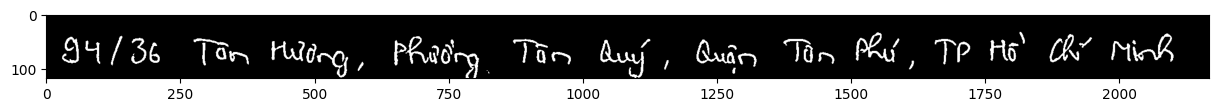

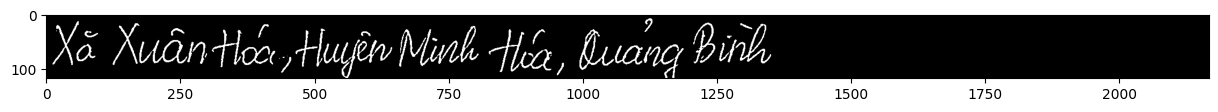

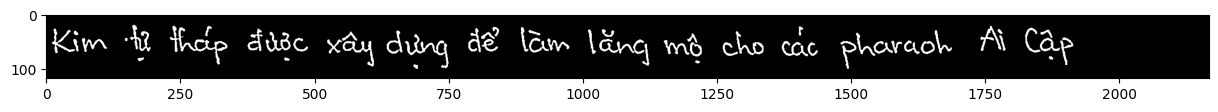

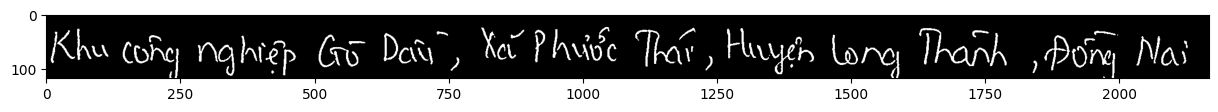

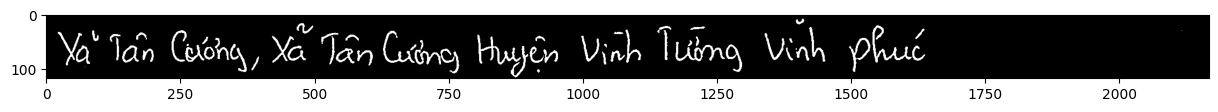

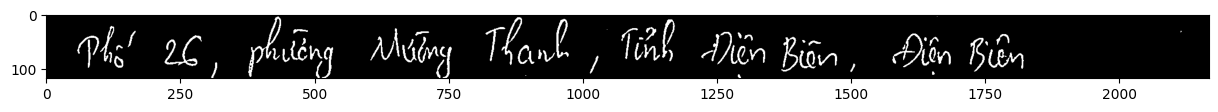

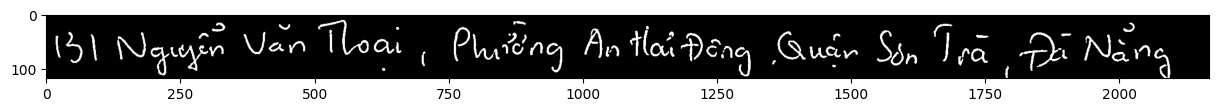

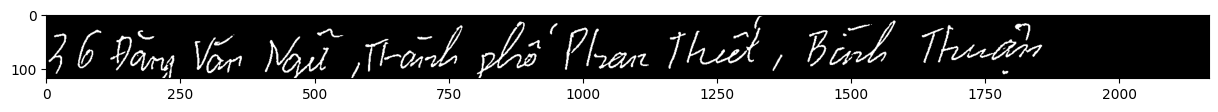

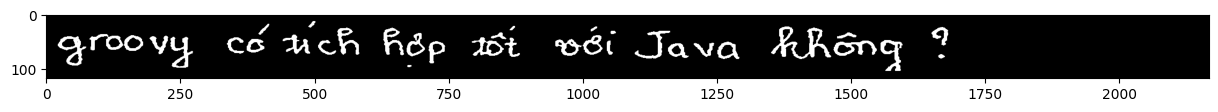

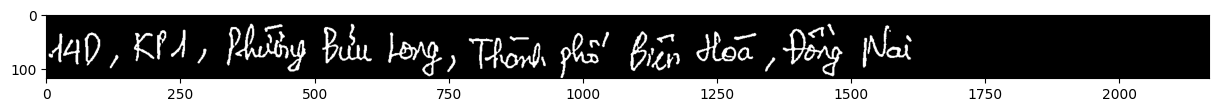

In [9]:
for i in range(35):
    plt.figure(figsize=(15,2))
    plt.imshow(training_img[i][:,:,0], cmap="gray")
    plt.show()

In [10]:
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for val_img_path in val_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(val_img_path), cv2.COLOR_BGR2GRAY)
    
    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(118/height*width),118))
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]
        
    img = np.pad(img, ((0,0),(0, 2167-width)), 'median')
    
    # YOUR PART: Blur it
    img = cv2.GaussianBlur(img, (5,5), 0)

    # YOUR PART: Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_filepath_label[val_img_path]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%500 == 0):
        print ("has processed test {} files".format(i))
print(resize_max_width)

has processed test 500 files
2167


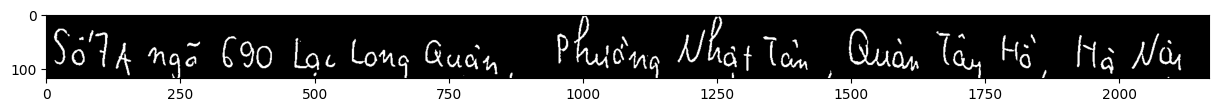

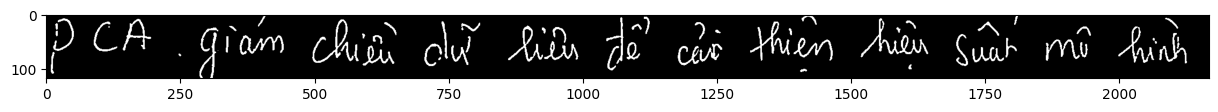

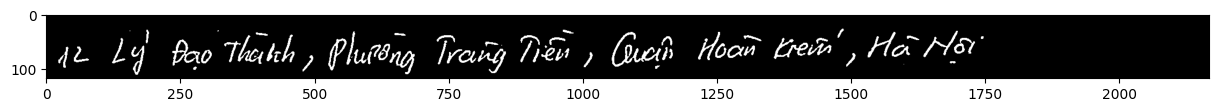

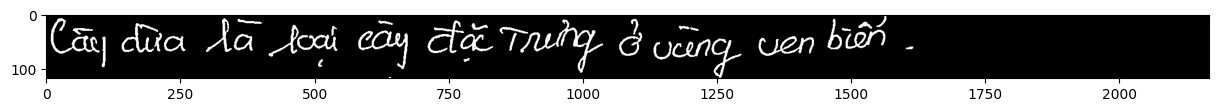

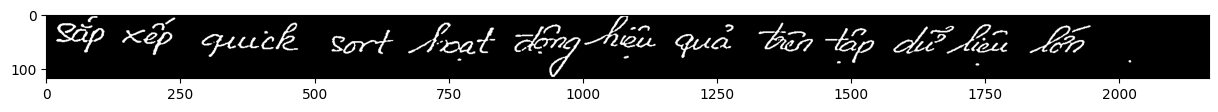

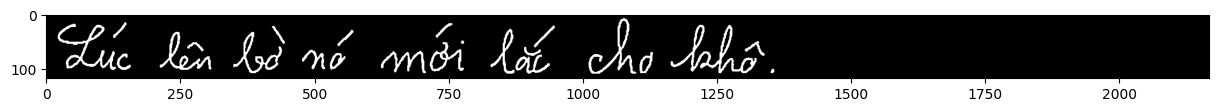

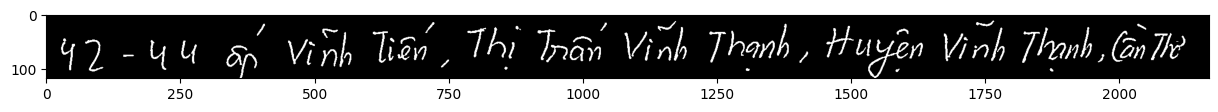

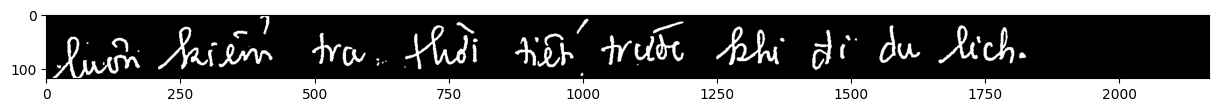

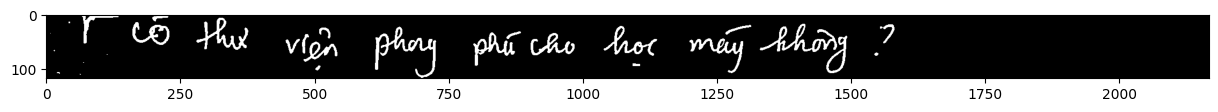

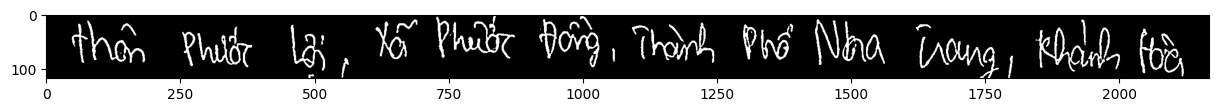

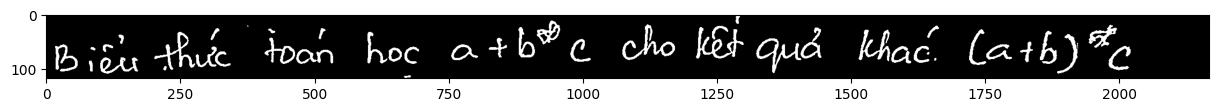

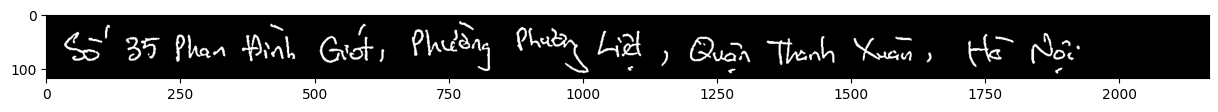

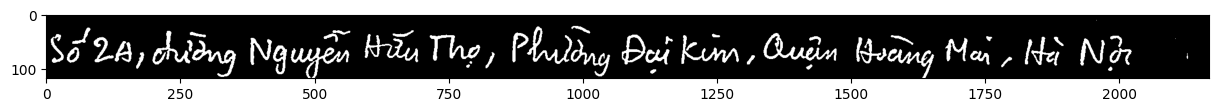

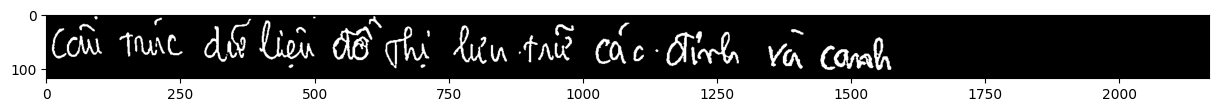

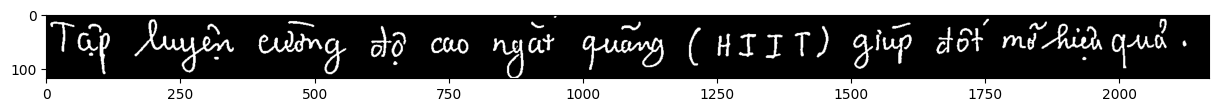

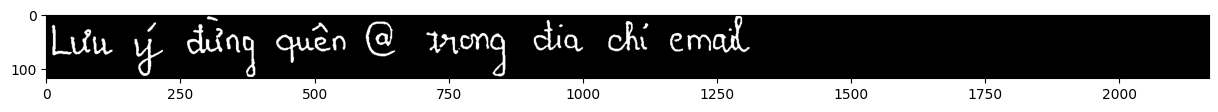

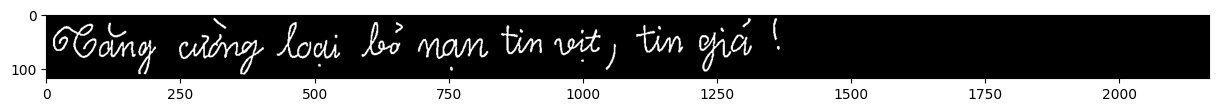

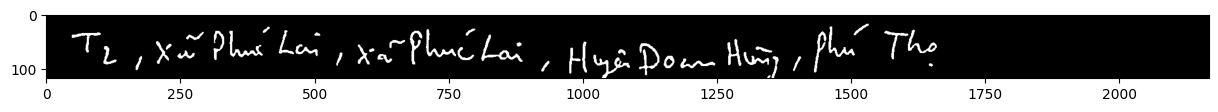

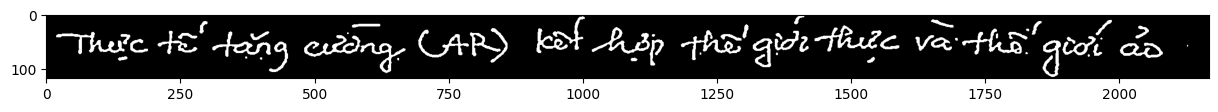

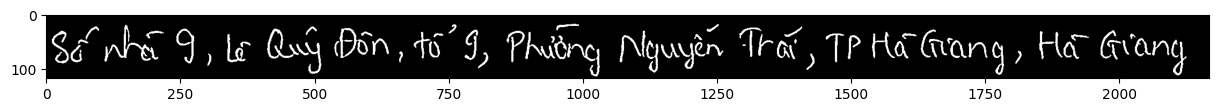

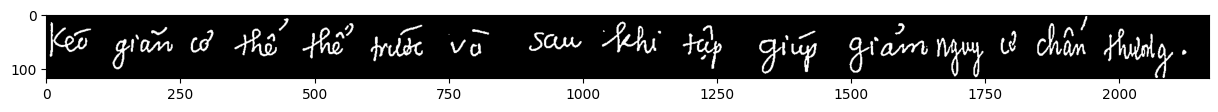

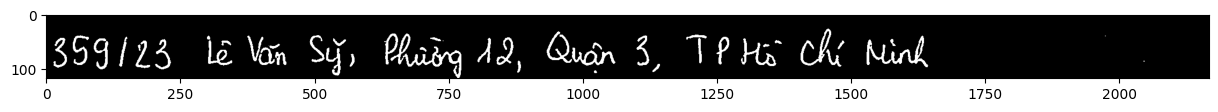

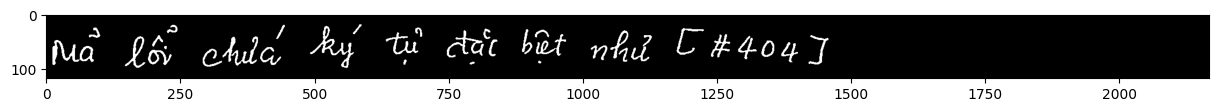

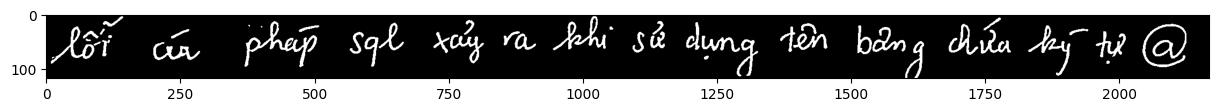

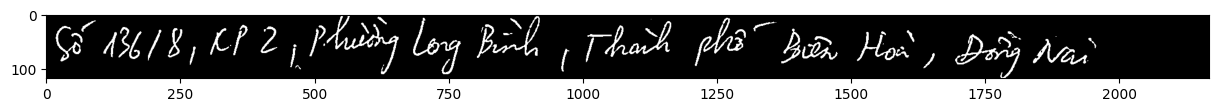

In [11]:
for i in range(25):
    plt.figure(figsize=(15,2))
    plt.imshow(valid_img[i][:,:,0], cmap="gray")
    plt.show()

In [12]:
max_label_len = 240

train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [13]:
inputs = Input(shape=(118,2167,1))
 
# Block 1
x = Conv2D(64, (3,3), padding='same')(inputs)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_1 = x 

# Block 2
x = Conv2D(128, (3,3), padding='same')(x)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_2 = x

# Block 3
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_3 = x

# Block4
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_3])
x = Activation('relu')(x)
x_4 = x

# Block5
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_5 = x

# Block6
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_5])
x = Activation('relu')(x)

# Block7
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 1))(x)
x = Activation('relu')(x)

# pooling layer with kernel size (2,2) to make the height/2 #(1,9,512)
x = MaxPool2D(pool_size=(3, 1))(x)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [14]:
act_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 118, 2167, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 118, 2167, │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 39, 722,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 39, 722,   │          0 │ max_pooling2d[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 39, 722,   │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 13, 240,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 13, 240,   │          0 │ max_pooling2d_1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 240,   │    295,168 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 240,   │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 13, 240,   │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 240,   │    590,080 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 240,   │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 240,   │          0 │ batch_normalizat… │
│                     │ 256)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 13, 240,   │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 240,   │  1,180,160 │ activation_3[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 240,   │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 13, 240,   │          0 │ batch_normalizat

 Total params: 22,000,047 (83.92 MB)

 Trainable params: 21,994,927 (83.90 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [15]:
max_label_len = 240

# Đầu vào cho labels, input_length, label_length
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Định nghĩa hàm loss CTC
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # Kết hợp CTC loss function với các tham số
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Đầu ra của mô hình
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# import tensorflow as tf
# import numpy as np

# # Kiểm tra số lượng GPU
# gpus = tf.config.list_physical_devices('GPU')
# print(f'Số lượng GPU có sẵn: {len(gpus)}')

# # Tạo MirroredStrategy để sử dụng nhiều GPU
# strategy = tf.distribute.MirroredStrategy()

# print('Số lượng thiết bị: {}'.format(strategy.num_replicas_in_sync))

# # Xây dựng và biên dịch mô hình trong phạm vi của strategy
# with strategy.scope():
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')
# Kiểm tra mô hình
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 118, 2167, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 118, 2167, │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 39, 722,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 39, 722,   │          0 │ max_pooling2d[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 39, 722,   │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 13, 240,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 13, 240,   │          0 │ max_pooling2d_1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 240,   │    295,168 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 240,   │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 13, 240,   │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 240,   │    590,080 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 240,   │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 240,   │          0 │ batch_normalizat… │
│                     │ 256)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 13, 240,   │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 240,   │  1,180,160 │ activation_3[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 240,   │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 13, 240,   │          0 │ batch_normalizat

 Total params: 22,000,047 (83.92 MB)

 Trainable params: 21,994,927 (83.90 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [16]:
# Callbacks for model training
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights.weights.h5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]

callbacks_list = callbacks

In [17]:
import tensorflow as tf

# Kiểm tra số lượng GPU có sẵn
gpus = tf.config.list_physical_devices('GPU')
print(f'Số lượng GPU có sẵn: {len(gpus)}')


Số lượng GPU có sẵn: 1


In [18]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our validating data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

batch_size = 32
epochs = 100

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 266.9745
Epoch 1: val_loss improved from inf to 198.77226, saving model to checkpoint_weights.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - loss: 266.4124 - val_loss: 198.7723 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 195.7667
Epoch 2: val_loss did not improve from 198.77226
91/91 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 195.7597 - val_loss: 264.4138 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 186.2046
Epoch 3: val_loss did not improve from 198.77226
91/91 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 186.1042 - val_loss: 264.5184 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 150.3020
Epoch 4: val_loss did not improve from 198.77226
91/91 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 150.1859 - val_loss: 333.2403 - learning_rate: 0.0010
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 111.8772
Epoch 5: val_l

In [19]:
model.save('vietnamese_ocr_model.h5')

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
import cv2
import os
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def preprocess_image(image_path, resize_max_width=2167):
    # Đọc ảnh
    img = cv2.imread(image_path)
    
    # Chuyển ảnh từ RGB sang grayscale (1 kênh)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Không thay đổi kích thước ảnh theo chiều cao và chiều rộng trong dataset này
    img = cv2.resize(img, (int(118 / img.shape[0] * img.shape[1]), 118))

    # Điều chỉnh kích thước ảnh nếu cần
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]

    # Thêm padding nếu ảnh nhỏ hơn chiều rộng mong muốn
    img = np.pad(img, ((0, 0), (0, resize_max_width - img.shape[1])), 'median')

    # Làm mờ ảnh
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Áp dụng threshold thích ứng
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Thêm chiều kênh (1 kênh)
    img = np.expand_dims(img, axis=2)

    # Chuẩn hóa ảnh
    img = img / 255.0
    
    # Thêm chiều batch (1, 118, 2167, 1)
    img = np.expand_dims(img, axis=0)
    
    return img

def show_image(image):
    # Hàm hiển thị ảnh
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')  # Tắt trục để dễ nhìn hơn
    plt.show()

inputs = Input(shape=(118,2167,1))
 
# Block 1
x = Conv2D(64, (3,3), padding='same')(inputs)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_1 = x 

# Block 2
x = Conv2D(128, (3,3), padding='same')(x)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_2 = x

# Block 3
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_3 = x

# Block4
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_3])
x = Activation('relu')(x)
x_4 = x

# Block5
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_5 = x

# Block6
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_5])
x = Activation('relu')(x)

# Block7
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 1))(x)
x = Activation('relu')(x)

# pooling layer with kernel size (2,2) to make the height/2 #(1,9,512)
x = MaxPool2D(pool_size=(3, 1))(x)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

model = Model(inputs, outputs)
model.load_weights('/kaggle/working/checkpoint_weights.weights.h5')

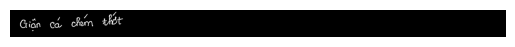

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Dự đoán = Giận cá chém thết


In [21]:
image_path = '/kaggle/input/test-hrc/test-3.jpg'
image = preprocess_image(image_path)
show_image(image)

prediction = model.predict(image)

out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

print("Dự đoán = ", end = '')
pred = ""
for p in out[0]:  # Duyệt qua các kết quả của dự đoán
    if int(p) != -1:
        pred += char_list[int(p)]
print(pred)

In [22]:
act_model.load_weights(os.path.join('/kaggle/working/checkpoint_weights.weights.h5'))
# predict outputs on validation images
NO_PREDICTS = 100
OFFSET=0
# prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
prediction = act_model.predict(valid_img)
prediction.shape

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step


(723, 240, 175)

In [23]:
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  Số 7A ngõ 690 Lạc Long Quân, Phường Nhật Tân, Quận Tây Hồ, Hà Nội
predicted text = Số 74 ngõ 690 Lạc Long Quân, Phường Nhật Tân, Quận Tây Hồ, Hà Nội
original_text  =  PCA giảm chiều dữ liệu để cải thiện hiệu suất mô hình
predicted text = DCA giảm chiều dữ liêu để cải thiện hiệu suất môi hình
original_text  =  12 Lý Đạo Thành, Phường Tràng Tiền, Quận Hoàn Kiếm, Hà Nội
predicted text = 12 Lý Đạo Thành, Phường Tràng Tiền, Quận Hoàn Kiến, Hà Nội
original_text  =  Cây dừa là loại cây đặc trưng ở vùng ven biển.
predicted text = Cây dừa là toại cây đặc Trưng ở cùng ven biển.
original_text  =  sắp xếp quick sort hoạt động hiệu quả trên tập dữ liệu lớn
predicted text = Sắp xếp quuck sont boạt động hiệu quả tiên tập dữ liệu ln
original_text  =  Lúc lên bờ nó mới lắc cho khô.
predicted text = Lúc lên bờ nó mới lắc cho khô
original_text  =  42-44, ấp Vĩnh Tiến, Thị Trấn Vĩnh Thạnh, Huyện Vĩnh Thạnh, Cần Thơ
predicted text = 42-44 ấp Vĩnh Tiến, Thị Trấn Vĩnh Thạnh, Huyện Vĩnh Thạn

In [24]:
!pip install editdistance

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 19.0 MB/s eta 0:00:00


In [25]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [26]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

In [27]:
print(e_corpus)

Metrics:
Character Error Rate: 0.08471104189873849
Word Error Rate:      0.2503647116338691
Sequence Error Rate:  0.8782849239280774


In [28]:
%load_ext tensorboard

In [29]:
%tensorboard --logdir logs